# Hyperelasticity #


## Hyperelasticity background ##

This example demonstrates the solution of a three-dimensional
elasticity problem. In addition to illustrating how to use
FunctionSpaces, Expressions and how to apply Dirichlet boundary
conditions, it focuses on how to:

* Minimize a non-quadratic functional
* Use automatic computation of the directional derivative
* Solve a nonlinear variational problem
* Define compiled sub-domains
* Use specific form compiler optimization options

## Equation and problem definition ##

By definition, boundary value problems for hyperelastic media can be
expressed as minimization problems, and the minimization approach is
adopted in this example. For a domain $\Omega \subset
\mathbb{R}^{d}$, where $d$ denotes the spatial dimension, the
task is to find the displacement field $u: \Omega \rightarrow
\mathbb{R}^{d}$ that minimises the total potential energy $\Pi$:

$$\min_{u \in V} \Pi,$$

where $V$ is a suitable function space that satisfies boundary
conditions on $u$.  The total potential energy is given by

\begin{equation}
   \Pi = \int_{\Omega} \psi(u) \, {\rm d} x
   - \int_{\Omega} B \cdot u \, {\rm d} x
   - \int_{\partial\Omega} T \cdot u \, {\rm d} s,
\end{equation}
where $\psi$ is the elastic stored energy density, $B$ is a
body force (per unit reference volume) and $T$ is a traction force
(per unit reference area).

At minimum points of $\Pi$, the directional derivative of $\Pi$
with respect to change in $u$

\begin{equation}
L(u; v) = D_{v} \Pi = \left. \frac{d \Pi(u + \epsilon v)}{d\epsilon} \right|_{\epsilon = 0}
\end{equation}

is equal to zero for all $v \in V$:

$$L(u; v) = 0 \ \ \ \  \forall \ v \in V.$$

To minimize the potential energy, a solution to the variational
equation above is sought. Depending on the potential energy
$\psi$, $L(u; v)$ can be nonlinear in $u$. In such a
case, the Jacobian of $L$ is required in order to solve this
problem using Newton's method. The Jacobian of $L$ is defined as

\begin{equation}
a(u; du, v) = D_{du} L = \left. \frac{d L(u + \epsilon du; v)}{d\epsilon} \right|_{\epsilon = 0} .
\end{equation}

### Elastic stored energy density ###

To define the elastic stored energy density, consider the deformation
gradient $F$

\begin{equation}
   F = I + \nabla u,
\end{equation}

the right Cauchy-Green tensor $C$

$$C = F^{T} F,$$

and the scalars  $J$ and $I_{c}$

\begin{align}
   J     &= \det(F), \\
   I_{c} &= {\rm trace}(C).
\end{align}

This demo considers a common neo-Hookean stored energy model of the form

$$
   \psi =  \frac{\mu}{2} (I_{c} - 3) - \mu \ln(J) + \frac{\lambda}{2}\ln(J)^{2},
$$
where $\mu$ and $\lambda$ are the Lame parameters. These
can be expressed in terms of the more common Young's modulus $E$
and Poisson ratio $\nu$ by:

\begin{equation}
    \lambda = \frac{E \nu}{(1 + \nu)(1 - 2\nu)}, \quad  \quad
    \mu     =  \frac{E}{2(1 + \nu)} .
\end{equation}

### Demo parameters ###

We consider a unit cube domain:
\begin{equation}
\Omega = (0, 1) \times (0, 1) \times (0, 1) \mbox{(unit cube)}
\end{equation}

We use the following definitions of the boundary and boundary conditions:

* $\Gamma_{D_{0}} = 0 \times (0, 1) \times (0, 1)$ (Dirichlet boundary)

* $\Gamma_{D_{1}} = 1 \times (0, 1) \times (0, 1)$ (Dirichlet boundary)

* $\Gamma_{N} = \partial \Omega \backslash \Gamma_{D}$ (Neumann boundary)

* On $\Gamma_{D_{0}}$:  $u = (0, 0, 0)$

* On $\Gamma_{D_{1}}$: 
\begin{align}
       u = (&0, \\
       &(0.5 + (y - 0.5)\cos(\pi/3) - (z - 0.5)\sin(\pi/3) - y)/2, \\
       &(0.5 + (y - 0.5)\sin(\pi/3) + (z - 0.5)\cos(\pi/3) - z))/2)
\end{align}

* On $\Gamma_{N}$: $T = (0.1, 0, 0)$

These are the body forces and material parameters used:

* $B = (0, -0.5, 0)$

* $E    = 10.0$

* $\nu  = 0.3$


## FEniCS Implementation ## 

First, the required modules are imported::

In [1]:
from fenics import *
import matplotlib.pyplot as plt
%matplotlib inline

The behavior of the form compiler FFC can be adjusted by prescribing
various parameters. Here, we want to use the UFLACS backend of FFC::

In [2]:
# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["representation"] = "uflacs"

The first line tells the form compiler to use C++ compiler optimizations when
compiling the generated code. The remainder is a dictionary of options which
will be passed to the form compiler. It lists the optimizations strategies
that we wish the form compiler to use when generating code.

First, we need a tetrahedral mesh of the domain and a function space
on this mesh. Here, we choose to create a unit cube mesh with 25 ( =
24 + 1) vertices in one direction and 17 ( = 16 + 1) vertices in the
other two direction. On this mesh, we define a function space of
continuous piecewise linear vector polynomials (a Lagrange vector
element space)::

In [3]:
# Create mesh and define function space
mesh = UnitCubeMesh(24, 16, 16)
V = VectorFunctionSpace(mesh, "Lagrange", 1)

Note that `VectorFunctionSpace` creates a
function space of vector fields. The dimension of the vector field
(the number of components) is assumed to be the same as the spatial
dimension, unless otherwise specified.

The portions of the boundary on which Dirichlet boundary conditions
will be applied are now defined:

In [4]:
# Mark boundary subdomians
left =  CompiledSubDomain("near(x[0], side) && on_boundary", side = 0.0)
right = CompiledSubDomain("near(x[0], side) && on_boundary", side = 1.0)

The boundary subdomain `left` corresponds to the part of the
boundary on which $x=0$ and the boundary subdomain `right`
corresponds to the part of the boundary on which $x=1$. Note
that C++ syntax is used in the `CompiledSubDomain` function since
the function will be automatically compiled into C++ code for
efficiency. The (built-in) variable `on_boundary` is true for points
on the boundary of a domain, and false otherwise.

The Dirichlet boundary values are defined using compiled expressions:

In [5]:
# Define Dirichlet boundary (x = 0 or x = 1)
c = Constant((0.0, 0.0, 0.0))
r = Expression(("scale*0.0",
                "scale*(y0 + (x[1] - y0)*cos(theta) - (x[2] - z0)*sin(theta) - x[1])",
                "scale*(z0 + (x[1] - y0)*sin(theta) + (x[2] - z0)*cos(theta) - x[2])"),
                scale = 0.5, y0 = 0.5, z0 = 0.5, theta = pi/3, degree=2)

Note the use of setting named parameters in the `Expression` for `r`.

The boundary subdomains and the boundary condition expressions are
collected together in two `DirichletBC` objects, one for each part of the
Dirichlet boundary:

In [6]:
bcl = DirichletBC(V, c, left)
bcr = DirichletBC(V, r, right)
bcs = [bcl, bcr]

The Dirichlet (essential) boundary conditions are constraints on the
function space $V$. The function space is therefore required as
an argument to `DirichletBC`.

Trial and test functions, and the most recent approximate displacement
`u` are defined on the finite element space `V`, and two objects
of type `Constant` are
declared for the body force (`B`) and traction (`T`) terms::

In [7]:
# Define functions
du = TrialFunction(V)            # Incremental displacement
v  = TestFunction(V)             # Test function
u  = Function(V)                 # Displacement from previous iteration
B  = Constant((0.0, -0.5, 0.0))  # Body force per unit volume
T  = Constant((0.1,  0.0, 0.0))  # Traction force on the boundary

In place of `Constant`, it is also possible to use `as_vector`, e.g.  
`B = as_vector( [0.0, -0.5, 0.0] )`. 
The advantage of Constant is that its values can be
changed without requiring re-generation and re-compilation of C++
code. On the other hand, using ``as_vector`` can eliminate some
function calls during assembly.

With the functions defined, the kinematic quantities involved in the model
are defined using UFL syntax::

In [8]:
# Kinematics
d = len(u)
I = Identity(d)             # Identity tensor
F = I + grad(u)             # Deformation gradient
C = F.T*F                   # Right Cauchy-Green tensor

# Invariants of deformation tensors
Ic = tr(C)
J  = det(F)

Next, the material parameters are set and the strain energy density
and the total potential energy are defined, again using UFL syntax::

In [9]:
# Elasticity parameters
E, nu = 10.0, 0.3
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))

# Stored strain energy density (compressible neo-Hookean model)
psi = (mu/2)*(Ic - 3) - mu*ln(J) + (lmbda/2)*(ln(J))**2

# Total potential energy
Pi = psi*dx - dot(B, u)*dx - dot(T, u)*ds

Just as for the body force and traction vectors, `Constant`
 has been used for the model
parameters ``mu`` and ``lmbda`` to avoid re-generation of C++ code
when changing model parameters. Note that ``lambda`` is a reserved
keyword in Python, hence the misspelling ``lmbda``.

Directional derivatives are now computed of $\Pi$ and $L$:

In [10]:
# Compute first variation of Pi (directional derivative about u in the direction of v)
F = derivative(Pi, u, v)

# Compute Jacobian of F
J = derivative(F, u, du)

The complete variational problem can now be solved by a single call to
`solve`:

In [11]:
# Solve variational problem
solve(F == 0, u, bcs, J=J)

Finally, the solution ``u`` is saved to a file named
``displacement.pvd`` in VTK format, and the deformed mesh is plotted
to the screen::

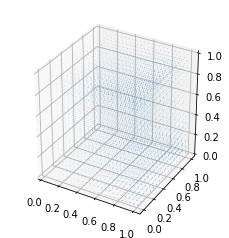

In [12]:
# Save solution in VTK format
file = File("displacement.pvd");
file << u;

# Plot solution
plot(u)
plt.show()